# Natural Language Processing (NLP)

**Natural language processing (NLP)** refers to computational techniques involving language.

## Word Cloud (Tag Cloud)

One approach to visualizing words and counts is **word clouds**, which artistically lay out the words with sizes proportional to their counts.

If you ever are forced to create a word cloud, `think about whether you can make the axes convey something`. For example, imagine that, for each of some collection of data science–related buzzwords, you have two numbers between 0 and 100—the first representing how frequently it appears in job postings, the second how frequently it appears on resumes.

In [2]:
# (word, job postings frequency, resume frequency)

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

def text_size(total: int) -> float:
    """
    equals 8 if total is 0 and 28 if total is 200
    """
    return 8 + total / 200 * 20

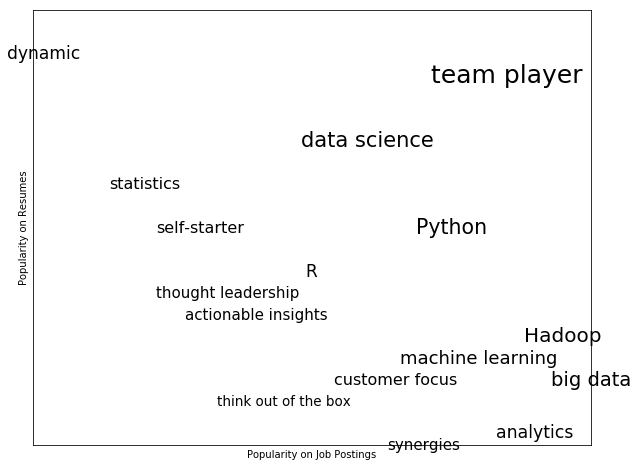

In [10]:
plt.figure(figsize=(10,8))

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word, 
             ha='center', va='center',
            size=text_size(job_popularity + resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.savefig('images/nlp1.png')
plt.show();

Horizontal position indicates posting popularity and vertical position indicates resume popularity, which produces a visualization that conveys a few insights.

## N-grams

Create thousands of web pages about data science so that your site will rank higher in search results for data science–related terms. One approach is to start with a corpus of documents and learn a statistical model of language. In our case, we’ll start with Mike Loukides’s essay [What is data science](https://www.oreilly.com/ideas/what-is-data-science)?

The first is that the apostrophes in the text are actually the Unicode character `u"\u2019"`.

In [1]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

In [2]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "article-body")   # find article-body div
regex = r"[\w']+|[\.]"                       # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

We certainly could (and likely should) clean this data further but for simplicity, we will not.


### Bigrams
Now that we have the text as a sequence of words, `we can model language in the following way:` given some starting word (say “book”) we look at all the words that follow it in the source documents (here “isn’t,” “a,” “shows,” “demonstrates,” and “teaches”). We randomly choose one of these to be the next word, and we repeat the process until we get to a period, which signifies the end of the sentence. We call this a bigram model, as it is determined completely by the frequencies of the bigrams (word pairs) in the original data.

What about a `starting word`? We can just pick randomly from words that follow a period. To start, let’s precompute the possible word transitions. Recall that zip stops when any of its inputs is done, so that `zip(document, document[1:])` gives us precisely the pairs of consecutive elements of document:

In [5]:
from collections import defaultdict
import random

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

In [7]:
generate_using_bigrams()

"Once you've made recommendations are data is that data scientist at LinkedIn ."

### Trigrams
We can make the sentences less gibberishy by looking at `trigrams`, triplets of consecutive words. (More generally, you might look at `n-grams` consisting of n consecutive words.

In [8]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

In [9]:
generate_using_trigrams()

"Once you've collected your training data perhaps a large number of identical subtasks which are then distributed across many nodes to provide eventual consistency but not absolute consistency and to have very flexible schema ."

Of course, they sound better because at each step the generation process has fewer choices, and at many steps only a single choice. This means that you frequently generate sentences (or at least long phrases) that were seen verbatim in the original data. Having more data would help; it would also work better if you collected `n-grams` from multiple essays about data science.

## Grammars

A different approach to modeling language is with **grammars**, rules for generating acceptable sentences.

In [10]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

The convention is that names starting with underscores refer to `rules` that need further expanding, and that other names are `terminals` that don’t need further processing.

So, for example, `"_S"` is the “sentence” rule, which produces a `"_NP"` (“noun phrase”) rule followed by a `"_VP"` (“verb phrase”) rule.

The verb phrase rule can produce either the `"_V"` (“verb”) rule, or the verb rule followed by the noun phrase rule.

Notice that the `"_NP"` rule contains itself in one of its productions. `Grammars can be recursive`, which allows even finite grammars like this to generate infinitely many different sentences.

`How do we generate sentences from this grammar?` We’ll start with a list containing the sentence rule ["_S"]. And then we’ll repeatedly expand each rule by replacing it with a randomly chosen one of its productions. We stop when we have a list consisting solely of terminals.

In [16]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
            
        print(tokens)

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

In [29]:
random.seed(2)
sentence = generate_sentence(grammar)

['_NP', '_VP']
['_N', '_VP']
['data science', '_VP']
['data science', '_V', '_NP']
['data science', 'trains', '_NP']
['data science', 'trains', '_A', '_NP', '_P', '_A', '_N']
['data science', 'trains', 'linear', '_NP', '_P', '_A', '_N']
['data science', 'trains', 'linear', '_N', '_P', '_A', '_N']
['data science', 'trains', 'linear', 'regression', '_P', '_A', '_N']
['data science', 'trains', 'linear', 'regression', 'about', '_A', '_N']
['data science', 'trains', 'linear', 'regression', 'about', 'logistic', '_N']
['data science', 'trains', 'linear', 'regression', 'about', 'logistic', 'regression']


## Gibbs Sampling

**Gibbs sampling** is a technique for generating samples from multidimensional distributions when we only know some of the conditional distributions.

In [30]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [33]:
direct_sample()

(4, 10)

The way **Gibbs sampling** works is that we start with any (valid) value for x and y and then repeatedly alternate replacing x with a random value picked conditional on y and replacing y with a random value picked conditional on x. After a number of iterations, the resulting values of x and y will represent a sample from the unconditional joint distribution:

In [31]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [36]:
compare_distributions(10)

defaultdict(<function __main__.compare_distributions.<locals>.<lambda>()>,
            {(3, 5): [1, 0],
             (5, 6): [0, 1],
             (4, 7): [1, 0],
             (6, 11): [0, 1],
             (5, 10): [3, 0],
             (6, 10): [0, 1],
             (6, 7): [1, 0],
             (1, 7): [0, 1],
             (4, 8): [1, 0],
             (6, 9): [0, 1],
             (5, 7): [1, 0],
             (3, 6): [0, 2],
             (3, 7): [1, 0],
             (3, 8): [0, 1],
             (3, 4): [1, 0],
             (1, 5): [0, 1],
             (2, 5): [0, 1]})

## Topic Modeling

Trying to identify the topics that underlie people's interests is a more sophisticated approach. A technique called **Latent Dirichlet Analysis (LDA)** is commonly used to identify common topics in a set of documents.

**LDA** has some similarities to the `Naive Bayes Classifier`, in that it assumes a probabilistic model for documents. The model assumes that:

- There is some fixed number K of topics.
- There is a random variable that assigns each topic an associated probability distribution over words. You should think of this distribution as the probability of seeing word w given topic k.
- There is another random variable that assigns each document a probability distribution over topics. You should think of this distribution as the mixture of topics in document d.
- Each word in a document was generated by first randomly picking a topic (from the document’s distribution of topics) and then randomly picking a word (from the topic’s distribution of words).

In particular, we have a collection of `documents` each of which is a list of words. And we have a corresponding collection of `document_topics` that assigns a topic (here a number between 0 and K – 1) to each word in each document.

So that the fifth word in the fourth document is: `documents[3][4]`, and the topic from which that word was chosen is: `document_topics[3][4]`.

This very explicitly defines each document’s distribution over topics, and it implicitly defines each topic’s distribution over words. We can `estimate the likelihood that topic 1 produces a certain word` by comparing how many times topic 1 produces that word with how many times topic 1 produces any word. 

Although these topics are just numbers, we can give them descriptive names by looking at the words on which they put the heaviest weight. We just have to somehow generate the `document_topics`. This is where **Gibbs sampling** comes into play.

We start by assigning every word in every document a topic completely at random. Now we go through each document one word at a time. For that word and document, we construct weights for each topic that depend on the (current) distribution of topics in that document and the (current) distribution of words for that topic. We then use those weights to sample a new topic for that word. `If we iterate this process many times, we will end up with a joint sample from the topic-word distribution and the document-topic distribution`.

In [37]:
# Randomly choose an index based on an arbitrary set of weights
def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

If you give it weights [1, 1, 3], then one-fifth of the time it will return 0, one-fifth of the time it will return 1, and three-fifths of the time it will return 2.

In [38]:
from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [39]:
# Users' interests
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

# We want to find K topics
K = 4

In [40]:
# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

D = len(documents)

def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [41]:
# Get a joint sample of the topics-word distribution and the documents distribution
# Use Gibbs sampling for this

import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 2714.12it/s]


In [43]:
# What are the most common words per topic?
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [44]:
# We can assign pottential topic names
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

In [45]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

## Word Vectors



One important innovation involves representing **words as low-dimensional vectors**. These vectors can be compared, added together, fed into machine learning models, or anything else you want to do with them. They usually have nice properties; for example, similar words tend to have similar vectors. That is, typically the word vector for big is pretty close to the word vector for large, so that a model operating on word vectors can (to some degree) handle things like synonymy for free.

TODO: return to it later (Data Science From Scratch)

## Resources

- [Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)
- [NLTK](http://www.nltk.org/) - a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum. There is a free [Natural Language Processing with Python](http://www.nltk.org/book/).
- [Gensim](https://radimrehurek.com/gensim/) - the most robust, efficient and hassle-free piece of software to realize unsupervised semantic modelling from plain text.
- [spaCy](https://spacy.io/) - an open-source software library for advanced Natural Language Processing.
- [AllenNLP](https://allennlp.org/) - an open-source NLP research library, built on PyTorch.